# Part 2.1 Incremental Treatment Effect Estimation (CATE) with Meta Learners; Application in Uplift Modeling

In [45]:
# Import necessary libraries
import numpy as np
import pandas as pd

# For data splitting and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# For model evaluation 
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score

# Base models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
plt.style.use('fivethirtyeight')
%matplotlib inline

# Suppress warnings for clean output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# pip install causeinfer
from causeinfer.data import hillstrom
hillstrom.download_hillstrom()

Attempting to download file to '/Users/ruidihong/Desktop/JM/uplift_CATE/datasets/hillstrom.csv'...
Download complete


In [3]:
data_raw = hillstrom.load_hillstrom(
    file_path="datasets/hillstrom.csv", format_covariates=False, normalize=False
)
df_full = pd.DataFrame(data_raw["dataset_full"], columns=data_raw["dataset_full_names"])
df_full.head()

,treatment,recency,history_segment,history,mens,womens,zip_code,newbie,channel,conversion,visit,spend
0,Womens E-Mail,10,100_200,142.44,1,0,Surburban,0,Phone,0,0,0.0
1,No E-Mail,6,200_350,329.08,1,1,Rural,1,Web,0,0,0.0
2,Womens E-Mail,7,100_200,180.65,0,1,Surburban,1,Web,0,0,0.0
3,Mens E-Mail,9,500_750,675.83,1,0,Rural,1,Web,0,0,0.0
4,Womens E-Mail,2,0_100,45.34,1,0,Urban,0,Web,0,0,0.0


In [4]:
# Convert multiple columns to categorical and float types
df_full = df_full.astype({
    "treatment": "string",
    "recency": "float",
    "history_segment": "category",
    "history": "float",
    "mens": "category",
    "womens": "category",
    "zip_code": "category",
    "newbie": "category",
    "channel": "category",
    "conversion": "int",
    "visit":"int",
    "spend": float,
})

# compute the visit rate, conversion rate, and averge spend for each treatment group 
result = df_full.groupby("treatment").agg(
    visit_rate=("visit", "mean"),
    conversion_rate=("conversion", "mean"),
    avg_spend=("spend", "mean"),
).reset_index()
result

,treatment,visit_rate,conversion_rate,avg_spend
0,Mens E-Mail,0.182757,0.012531,1.422617
1,No E-Mail,0.106167,0.005726,0.652789
2,Womens E-Mail,0.151400,0.008837,1.077202


In [5]:
# examine if the difference are statistically significant
from scipy.stats import ttest_ind

treatment_0 = df_full[df_full.treatment == "No E-Mail"]
treatment_1 = df_full[df_full.treatment == "Mens E-Mail"]
treatment_2 = df_full[df_full.treatment == "Womens E-Mail"]

control_vs_mens = ttest_ind(treatment_0.visit, treatment_1.visit).pvalue * 3
control_vs_womens = ttest_ind(treatment_0.visit, treatment_2.visit).pvalue * 3
mens_vs_womens = ttest_ind(treatment_1.visit, treatment_2.visit).pvalue * 3

print(f"""Each group sees a statistically significant difference in visit rate: 
      p_value between control and mens: {control_vs_mens:.4f},
      p_value between control and womens: {control_vs_womens:.4f},
      p_value between mens and womens: {mens_vs_womens:.4f}""")

Each group sees a statistically significant difference in visit rate: 
      p_value between control and mens: 0.0000,
      p_value between control and womens: 0.0000,
      p_value between mens and womens: 0.0000


In [6]:
# F-test for group means on visit 
from scipy.stats import f_oneway
f_oneway(treatment_0.visit, treatment_1.visit, treatment_2.visit)

F_onewayResult(statistic=254.22234204513532, pvalue=1.0688426763224876e-110)

## Part 0: Data Exploration

In [7]:
w_df = df_full[(df_full.treatment == "Womens E-Mail") | (df_full.treatment == "No E-Mail")]
m_df = df_full[(df_full.treatment == "Mens E-Mail") | (df_full.treatment == "No E-Mail")]

#### a. Check Randomization Assumption

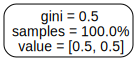

In [8]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pandas as pd

# Assuming X_features and T are already defined correctly
X_features = w_df.iloc[:, 1:-3]  # Select the feature data
T = w_df['treatment']  # Select the treatment column

# Create dummy variables for categorical features in the actual data
data_dummy = pd.get_dummies(X_features, drop_first=False)

# Instantiate and fit the DecisionTreeClassifier
tree = DecisionTreeClassifier(
    class_weight="balanced",  # Handle class imbalance
    min_impurity_decrease=0.001  # Pruning condition
)

# Fit the model with the dummy-encoded data
tree.fit(data_dummy, T)

# Export the tree structure to a DOT format (string)
dot_data = export_graphviz(
    tree, 
    feature_names=data_dummy.columns,  # Use the dummy-encoded feature names
    filled=True,  # Add color to nodes
    rounded=True,  # Round edges of the nodes
    special_characters=True,  # Ensure special characters are displayed
    proportion=True  # Show proportions of samples in each node
)

# Use graphviz to display the tree directly in Jupyter notebook
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Save the file if needed

# Display the graph in the notebook
graph

The decision tree result shows that none of the features are good at predicting treatment assignment. This suggests that the experiment assignment are random.

#### b. Check for Imbalance


3 Types of Imbalance:
1. Class imbalance in Outcomes Y 
2. Imbalance in Treatment Assignment T
3. Imbalance in Covraites Across Treatment Groups X

In [9]:
w_df.groupby(["treatment", "visit", "conversion"])['spend'].agg(
    count = "size", 
    total_spend = "sum",
    average_spend = "mean"
)

count  total_spend  average_spend
treatment     visit conversion                                   
No E-Mail     0     0           19044         0.00       0.000000
              1     0            2140         0.00       0.000000
                    1             122     13908.33     114.002705
Womens E-Mail 0     0           18149         0.00       0.000000
              1     0            3049         0.00       0.000000
                    1             189     23038.11     121.894762

In [10]:
w_df.groupby("treatment")[['conversion', 'visit', 'spend']].agg(["size", "mean"]).reset_index()

treatment conversion            visit            spend          
                       size      mean   size      mean   size      mean
0      No E-Mail      21306  0.005726  21306  0.106167  21306  0.652789
1  Womens E-Mail      21387  0.008837  21387  0.151400  21387  1.077202

Text(0.5, 1.0, 'Control Group')

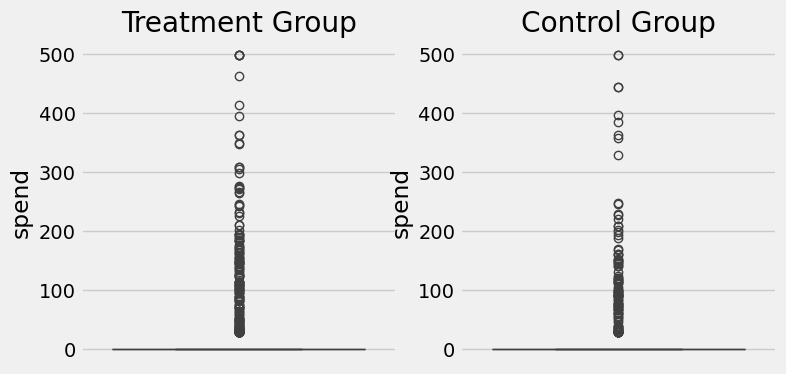

In [11]:
# plot the spend distribution for each treatment group
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(w_df.loc[df_full["treatment"] == "Womens E-Mail", "spend"], ax=ax[0])
ax[0].set_title("Treatment Group")
sns.boxplot(w_df.loc[df_full["treatment"] == "No E-Mail", "spend"], ax=ax[1])
ax[1].set_title("Control Group")

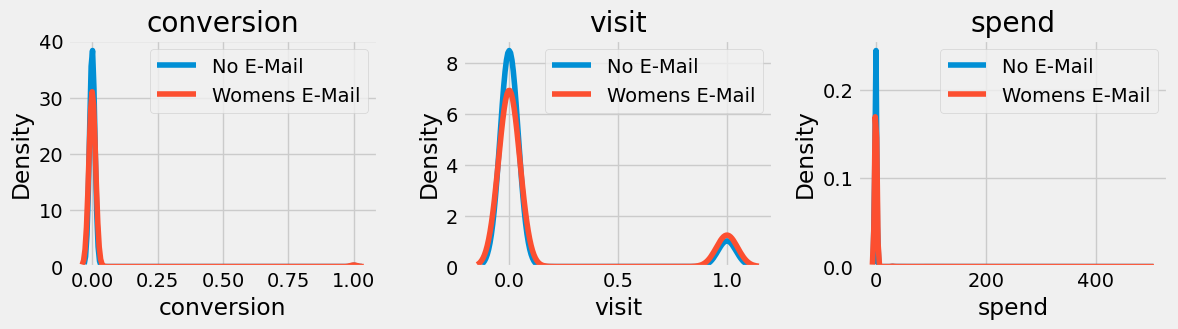

In [12]:
# Select only numeric columns for plotting
col_to_plot = w_df.select_dtypes(include=['float64', 'int64']).columns[2:]

# Plot the kernel density of each feature by treatment group
fig, ax = plt.subplots(4, 3, figsize=(12, 12))  # Create a grid of 4x3 subplots
ax = ax.flatten()  # Flatten the 2D array of axes for easier access

for i, col in enumerate(col_to_plot):
    sns.kdeplot(w_df.loc[w_df.treatment == "No E-Mail", col], ax=ax[i], label="No E-Mail")
    sns.kdeplot(w_df.loc[w_df.treatment == "Womens E-Mail", col], ax=ax[i], label="Womens E-Mail")
    ax[i].set_title(col)
    ax[i].legend()  # Add legend to each subplot

# Remove any extra subplots if there are fewer columns than subplots
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [13]:
# code category to ordinal 
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
w_df_copy = w_df.copy()
w_df_copy["history_segment"] = encoder.fit_transform(w_df_copy[["history_segment"]])
w_df_copy["mens"] = encoder.fit_transform(w_df_copy[["mens"]])
w_df_copy["womens"] = encoder.fit_transform(w_df_copy[["womens"]])
w_df_copy["zip_code"] = encoder.fit_transform(w_df_copy[["zip_code"]])
w_df_copy["newbie"] = encoder.fit_transform(w_df_copy[["newbie"]])
w_df_copy["channel"] = encoder.fit_transform(w_df_copy[["channel"]])

##### Check Imbalance in Covariates

In [14]:
w_df_copy.groupby('treatment')[X_features.columns].mean()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
treatment,,,,,,,,
No E-Mail,5.749695,2.004506,240.882653,0.553224,0.547639,1.253591,0.501971,1.317610
Womens E-Mail,5.767850,2.009024,242.536633,0.548932,0.550101,1.251321,0.503250,1.316781


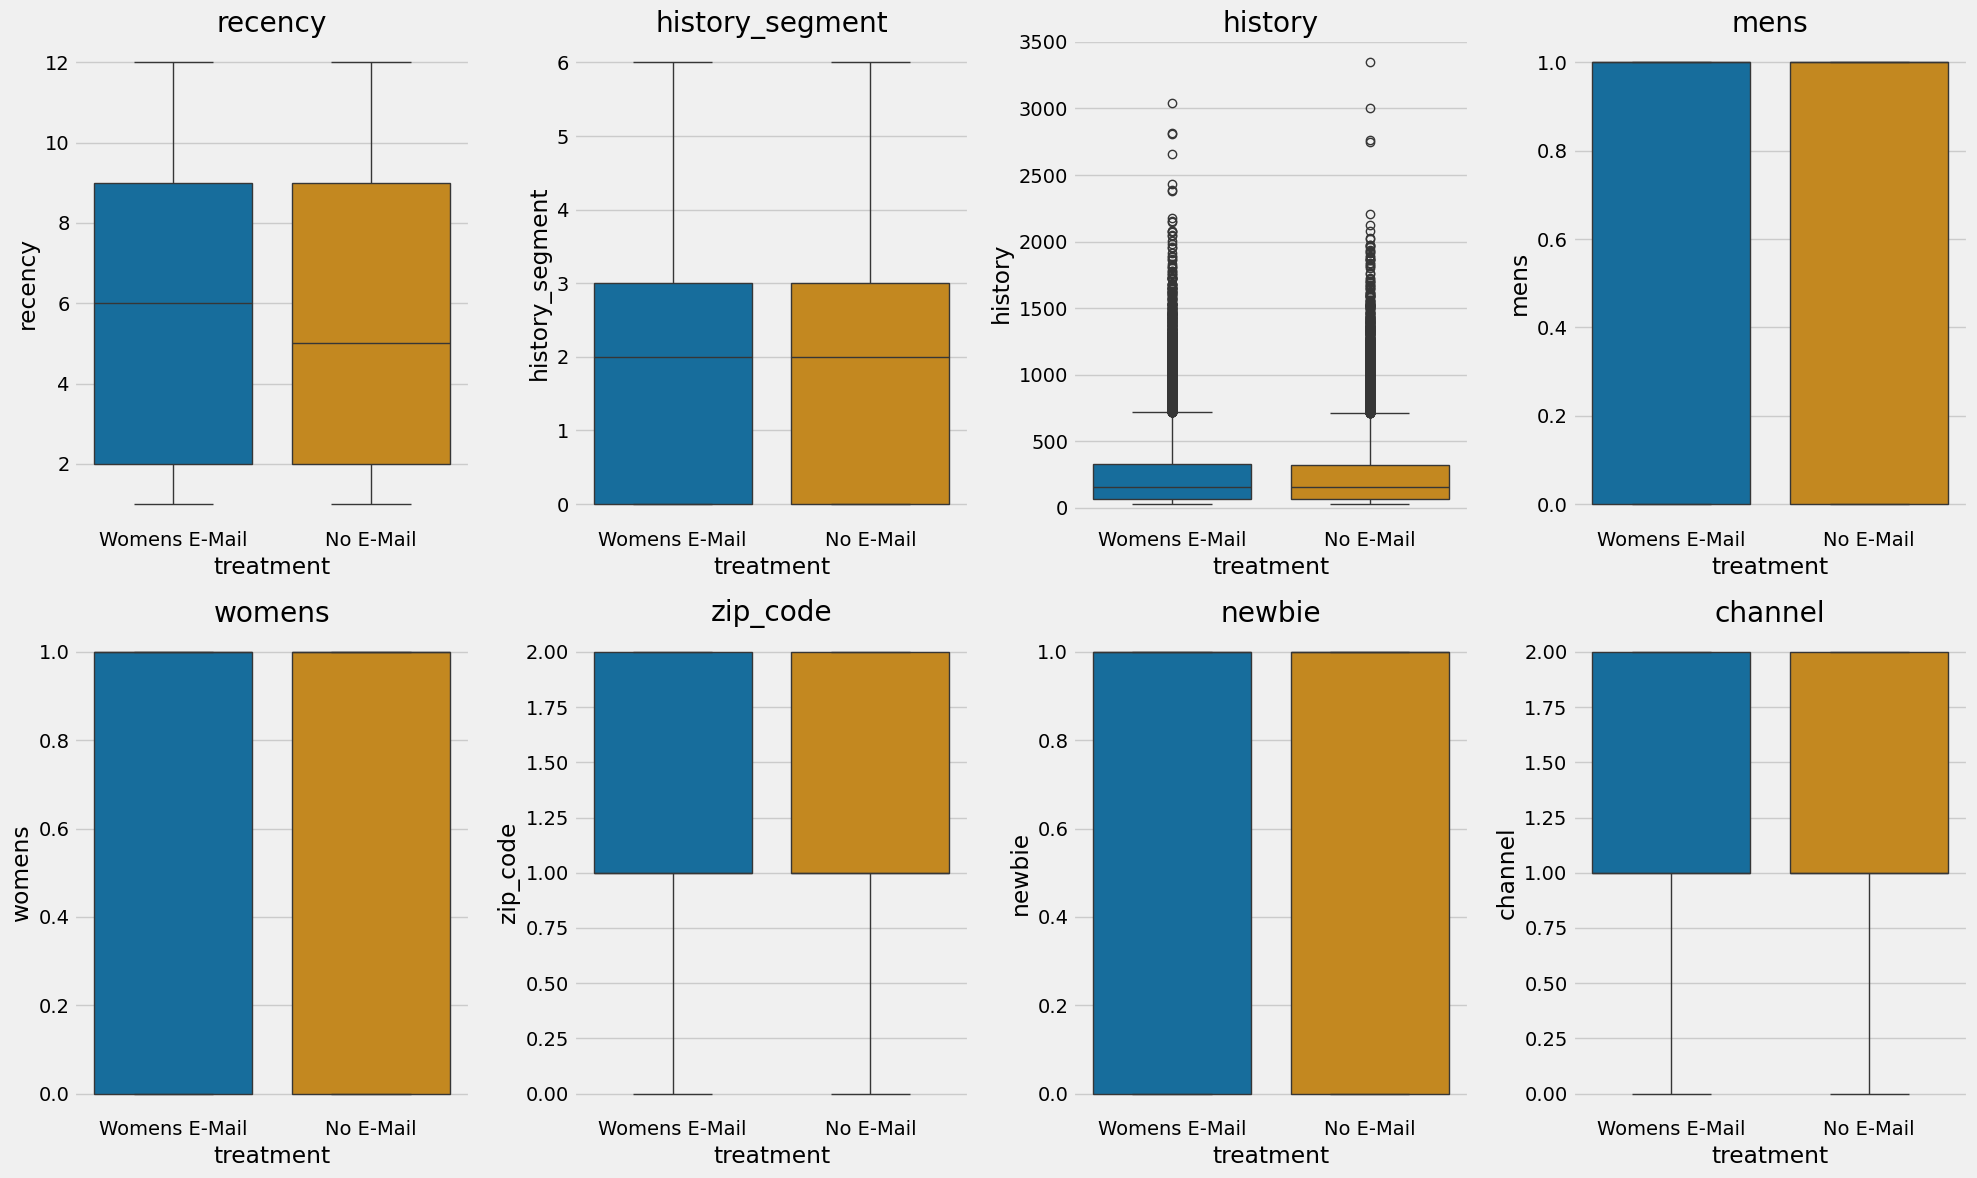

In [58]:
# Plot boxplot for each feature by treatment group
fig, ax = plt.subplots(2, 4, figsize=(20, 12))  # Create a grid of 4x3 subplots
ax = ax.flatten()  # Flatten the 2D array of axes for easier access

for i, col in enumerate(X_features.columns):
    sns.boxplot(x="treatment", y=col, data=w_df_copy, ax=ax[i], palette="colorblind")  # Use a color palette for different treatments
    ax[i].set_title(col)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


## Part 1: Regression For Benchmarking

In [15]:
# focus on women's campaign performance 
w_df = df_full[(df_full.treatment == "Womens E-Mail") | (df_full.treatment == "No E-Mail")]

# code womens E-mail to 1 and No Email to 0
w_df['treatment'] = np.where(w_df['treatment'] == 'Womens E-Mail', 1, 0)

# split w_df into train and test set
w_df_train, w_df_test = train_test_split(w_df, test_size=0.4, random_state=42)

# defined the covariates 
X_reg = ['C(zip_code)', 'C(newbie)', 'C(channel)', 'C(mens)', 'C(womens)', 'recency', 'history']

# interact each covariataes with the treatment variable using * operator 
import statsmodels.formula.api as smf
regr_cate = smf.ols(f"spend ~ treatment * ({' + '.join(X_reg)})", data=w_df_train).fit()

## predict cate on the test dataset 
# Create copies of the dataset for treated and control scenarios
w_df_test_treated = w_df_test.copy()
w_df_test_control = w_df_test.copy()

# set 'treatment' to 1 for the treated scenario
w_df_test_treated['treatment'] = 1

# set 'treatment' to 0 for the control scenario
w_df_test_control['treatment'] = 0

# compute cate 
cate_pred_ols = regr_cate.predict(w_df_test_treated) - regr_cate.predict(w_df_test_control)

Text(0.5, 1.0, 'Residual Plot')

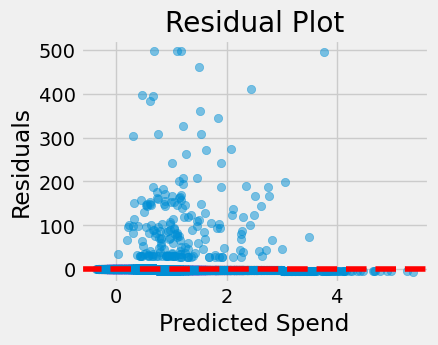

In [39]:
import matplotlib.pyplot as plt
# plot residual plot 
plt.figure(figsize=(4, 3))
plt.scatter(regr_cate.predict(w_df_train), regr_cate.resid, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Spend")
plt.ylabel("Residuals")
plt.title("Residual Plot")

## Part 3: Meta Learners for CATE


**Prepare Data For ML Model Training**

In [17]:
w_df_ml = w_df.drop(columns="history_segment") #drop history_segment since we have numeric history data
w_df_ml = pd.get_dummies(w_df_ml, columns=["zip_code", "newbie", "channel"], drop_first=True)
w_df_ml = w_df_ml.astype({col: 'int' for col in w_df_ml.select_dtypes(include=['bool', 'category']).columns})

# split w_df into train and test set
w_df_train_ml, w_df_test_ml = train_test_split(w_df_ml, test_size=0.4, random_state=42)

In [18]:
y_spend = "spend"
y_conv = "conversion"
T = "treatment"
X = list(w_df_ml.drop(columns=[T] + ["visit", "conversion", "spend"]).columns)

### 1. S-learner 

We use a single ML model $\hat{\mu_s}$ to estimate:
$$\mu(x) = E[Y|T, X]$$

The model outputs counterfactual predictions: it make predictions under different treatment assignments. 

$$\hat{\tau}(x)_i = M_s (X_i, T=1) - M_s(X_i, T=0)$$

In [19]:
# S-learner
from lightgbm import LGBMRegressor

w_s_learner = LGBMRegressor()
w_s_learner.fit(w_df_train_ml[X + [T]], w_df_train_ml[y_spend])

w_df_test_ml['spend_pred_treated'] = w_s_learner.predict(w_df_test_ml[X+[T]].assign(treatment=1))
w_df_test_ml['spend_pred_control'] = w_s_learner.predict(w_df_test_ml[X+[T]].assign(treatment=0))

s_learner_pred = w_df_test_ml['spend_pred_treated'] - w_df_test_ml['spend_pred_control']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 25615, number of used features: 10
[LightGBM] [Info] Start training from score 0.871482


In [20]:
# make prediction on w_s_train_ml
s_learner_pred_train = w_s_learner.predict(w_df_train_ml[X + [T]])

### 2. T-learner 

**Objective**: Accurately model the potential outcome $\mu_T (x) = E[Y|T=t, X=x]$, then obtain CATE estimate indirectly by the difference between these two, $\hat{\tau}(X_i) = \hat{\mu_1} (X_i) - \hat{\mu_0}(X_i)$


The potential outcomes models are respectively trained on the treatment data and other on the control data. 
* $\mu_0(x) = E[Y|T=0, X]$
* $\mu_1(x) = E[Y|T=1, X]$

Then, we can make counterfactural predictions for each treatmnet and get the CATE:
$$\hat{\tau}(x)_i = \hat{\mu_1}(X_i) - \hat{\mu_0}(X_i)$$



In [21]:
np.random.seed(42)

m0_lgbm = LGBMRegressor()
m1_lgbm = LGBMRegressor()

# Ensure 'X' and 'y_spend' are properly defined
m0_lgbm.fit(w_df_train_ml.query("treatment == 0")[X], w_df_train_ml.query("treatment == 0")[['spend']])
m1_lgbm.fit(w_df_train_ml.query("treatment == 1")[X], w_df_train_ml.query("treatment == 1")[['spend']])

t_learner_pred = m1_lgbm.predict(w_df_test_ml[X]) - m0_lgbm.predict(w_df_test_ml[X])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 12852, number of used features: 9
[LightGBM] [Info] Start training from score 0.614496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 12763, number of used features: 9
[LightGBM] [Info] Start training from score 1.130260


In [22]:
t_learner_pred_train = m1_lgbm.predict(w_df_train_ml[X]) - m0_lgbm.predict(w_df_train_ml[X])

### 3. X-Learner

X-learner has two stages and a propensity score model. 
The first stage is identitcal to the T-leaner. 

* $\hat{\mu}_0 (x) \approx E[Y|T=0, X]$
* $\hat{\mu}_1 (x) \approx E[Y|T=1, X]$


For the second stage, we first impute the missing potential outcomes using the fitted models:
 $$\hat{\tau}(X, T=0) = \underbrace{\hat{\mu}_1 (X, T=0)}_{estimated \space treated \space outcome \space for \space the \space control } - Y_{T=0}$$
$$\hat{\tau}(X, T=1) = \underbrace{\hat{\mu}_1 (X, T=1)}_{estimated \space control \space outcome \space for \space the \space treated} - Y_{T=1}$$

Then we fit two more models to predict these estiamted effects. These model swill approximate the CATE on the control and treated popualtion respectively:

$$\hat{\mu}(X)_{\tau 0} \approx E[\tau(X) | T=0] $$
$$\hat{\mu}(X)_{\tau 1} \approx E[\tau(X) | T=1] $$

Lastly, we combine theset two using a propensity score model. $$\hat{e}(x)$$
$$\hat{\tau}(x) = \hat{\mu}(X)_{\tau 0} \hat{e}(x) + \hat{\mu}(X)_{\tau 1} (1-\hat{e}(x))$$


In [23]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor

# propensity score model 
ps_model = LogisticRegression(penalty=None)
ps_model.fit(w_df_train_ml[X], w_df_train_ml[T])

# first stage model 
train_t0 = w_df_train_ml.query(f"{T} == 0")
train_t1 = w_df_train_ml.query(f"{T} == 1")

m0 = LGBMRegressor()
m1 = LGBMRegressor()

m0.fit(
    train_t0[X],
    train_t0['spend'],
    sample_weight=1/ps_model.predict_proba(train_t0[X])[:, 0]
)

m1.fit(
    train_t1[X],
    train_t1['spend'],
    sample_weight=1/ps_model.predict_proba(train_t1[X])[:, 1]
)

# predict the treatment effect and fit the 2nd stage models

# second stage
tau_hat_0 = m1.predict(w_df_train_ml[X]) - w_df_train_ml['spend']
tau_hat_1 = w_df_train_ml['spend'] - m0.predict(w_df_train_ml[X])

m_tau_0 = LGBMRegressor()
m_tau_1 = LGBMRegressor()

m_tau_0.fit(w_df_train_ml[X], tau_hat_0)
m_tau_1.fit(w_df_train_ml[X], tau_hat_1)

# obtain CATE: combine the predictions form the 2nd stage models using propensity score model

ps_test = ps_model.predict_proba(w_df_test_ml[X])[:, 1]

x_learner_pred = ps_test * m_tau_0.predict(w_df_test_ml[X]) + (1 - ps_test) * m_tau_1.predict(w_df_test_ml[X]) 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 12852, number of used features: 9
[LightGBM] [Info] Start training from score 0.614448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 12763, number of used features: 9
[LightGBM] [Info] Start training from score 1.129226
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

In [24]:
x_learner_pred_train = ps_model.predict_proba(w_df_train_ml[X])[:, 1] * m_tau_0.predict(w_df_train_ml[X]) + (1 - ps_model.predict_proba(w_df_train_ml[X])[:, 1]) * m_tau_1.predict(w_df_train_ml[X])

### 4. Double ML



Double ML uses Ml models whne constructing the outcome and the treatment residuals:
$$Y_i - \hat{\mu_y}(X_i) = \tau \cdot (T_i - \hat{\mu_t}(X_i)) + \epsilon_i$$
* $\hat{\mu_y}(X_i)$ estimates $E[Y|X]$
* $\hat{\mu_t}(X_i)$ estimates $E[T|X]$

Steps: 
1. Estiamte the outcome Y with X using ML regression model $\mu_y$
2. Estiamte the treatment T with features X using ML regression model $\mu_t$
3. Obtain the residuals $\tilde{Y} = Y - \mu_y(X)$ and $\tilde{T} = T -\mu_t(X)$
4. Regress the residuals of the outcome on the residuals of the treatment: $\tilde{Y} = \alpha + \tau \tilde{T}$




In [25]:
from sklearn.model_selection import cross_val_predict

debias_m = LGBMRegressor()
denoise_m = LGBMRegressor()

t_res = w_df_train_ml[T] - cross_val_predict(debias_m, w_df_train_ml[X], w_df_train_ml[T], cv=5, verbose=0)
y_res = w_df_train_ml['spend'] - cross_val_predict(denoise_m, w_df_train_ml[X], w_df_train_ml['spend'], cv=5, verbose=0)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 20492, number of used features: 9
[LightGBM] [Info] Start training from score 0.497658
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 20492, number of used features: 9
[LightGBM] [Info] Start training from score 0.497658
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2

In [26]:
y_star = y_res / t_res
w = t_res**2

r_learner_cate_model = LGBMRegressor().fit(w_df_train_ml[X], y_star, sample_weight=w)
r_learner_pred = r_learner_cate_model.predict(w_df_test_ml[X]) 
# it direclty outputs CATE estimates 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 282
[LightGBM] [Info] Number of data points in the train set: 25615, number of used features: 9
[LightGBM] [Info] Start training from score 0.532883


In [27]:
r_learner_pred_train = r_learner_cate_model.predict(w_df_train_ml[X])

## Compare performance of Meta-Learners

In [28]:
w_train_pred_spend = pd.DataFrame({
    "treatment": w_df_train_ml[T],
    "spend": w_df_train_ml['spend'],
    's_learner': s_learner_pred_train,
    't_learner': t_learner_pred_train,
    'x_learner': x_learner_pred_train,
    'r_learner': r_learner_pred_train
})
w_train_pred_spend.head()

,treatment,spend,s_learner,t_learner,x_learner,r_learner
40744,1,0.0,0.348627,-0.347344,0.157288,-0.635045
31353,0,0.0,0.138614,1.388276,0.132155,0.001948
429,0,0.0,0.277770,-1.121853,0.035705,-0.524622
7575,1,0.0,0.310341,0.641826,0.152294,0.106910
26670,1,0.0,0.859144,-3.922057,-0.739319,0.144426


In [29]:
w_test_pred_spend = pd.DataFrame({
    "treatment": w_df_test_ml[T],
    "spend": w_df_test_ml['spend'],
    "rand_m_pred": np.random.normal(0, 1, len(w_df_test_ml)), # add a random prediction to visualize 
    "s_learner_pred": s_learner_pred,
    # "cate_pred_gbr": model_gbr_pred,
    "cate_pred_ols": cate_pred_ols,
    "t_learner_pred": t_learner_pred,
    "x_learner_pred": x_learner_pred,
    "r_learner_pred": r_learner_pred,
})
w_test_pred_spend.head()

,treatment,spend,rand_m_pred,s_learner_pred,cate_pred_ols,t_learner_pred,x_learner_pred,r_learner_pred
7730,0,0.0,0.496714,-0.356432,2.002764,4.731765,0.174754,-2.100072
17594,1,0.0,-0.138264,0.127923,0.280278,0.093168,0.160275,0.305481
14481,1,0.0,0.647689,0.215524,1.266302,2.179689,0.228775,0.240010
20003,1,0.0,1.523030,-0.882576,0.324665,-3.981744,-0.058506,-8.545384
19981,0,0.0,-0.234153,0.390326,0.638935,-0.326264,0.088432,0.121348


### a. Effect By Model Quantile

Goal: order units from more sensitive to the treatment effect to less sensitive ones.

Order units by the CATE prediction and hope it also orders them by the real CATE. 

Since the treatmnet is randomly assigned, we don't have to worry about confouding bias. To estimate the effect for a group of units, we compare the outcome between the treated and untreated in the group x. 


In [30]:
from evaluation_utils import *

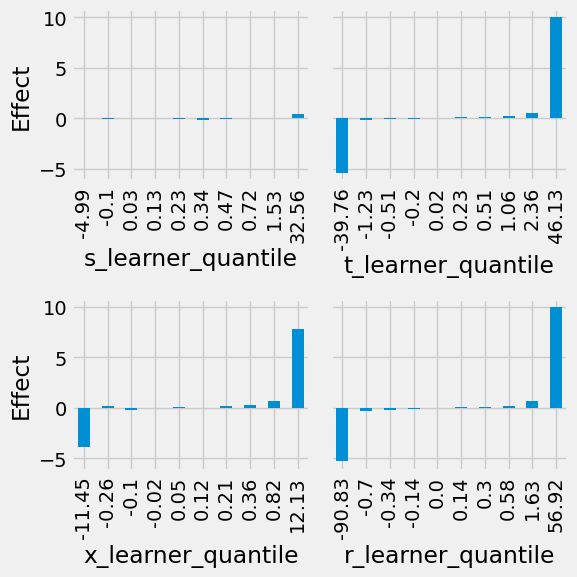

In [31]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, sharey=True, figsize=(6, 6))

# Flatten the axs array to make it easier to iterate over
axs = axs.flatten()

# Iterate through the columns excluding 'treatment' and 'spend'
for m, ax in zip(w_train_pred_spend.columns.drop(["treatment", "spend"]), axs):
    effect_by_quantile(w_train_pred_spend, m, "spend", "treatment").plot.bar(ax=ax)
    ax.set_ylabel("Effect")

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()


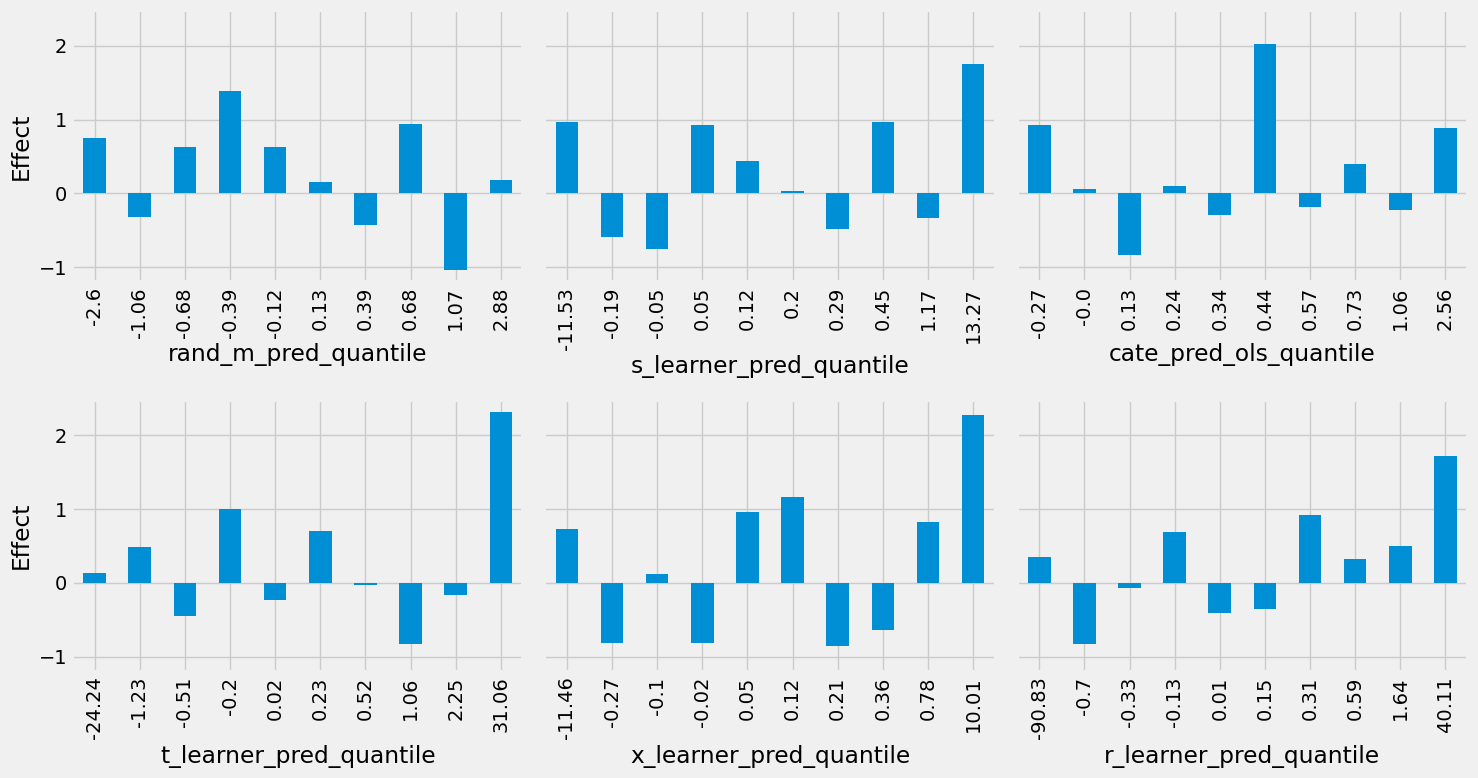

In [32]:
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(2, 3, sharey=True, figsize=(15, 8))

# Flatten the axs array to make it easier to iterate over
axs = axs.flatten()

# Iterate through the columns excluding 'treatment' and 'spend'
for m, ax in zip(w_test_pred_spend.columns.drop(["treatment", "spend"]), axs):
    effect_by_quantile(w_test_pred_spend, m, "spend", "treatment").plot.bar(ax=ax)
    ax.set_ylabel("Effect")

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

### b. Cummulative Effect

We first sort the data by a score, the following code uses the predictions as the sorting criteria. Then we estiamte the effect by the top x% and so forth based on that ordering. Then we add the following x% and calcualte the treatment effect.  

The cumulative effect curve will start high and gradually decrease to the Average Treatment Effect (ATE) when the score used to sort the data is effective at ordering the true Conditional Average Treatment Effect (CATE). Conversely, if the score is not good at ordering the true CATE, the curve will quickly converge to the ATE or fluctuate around it.

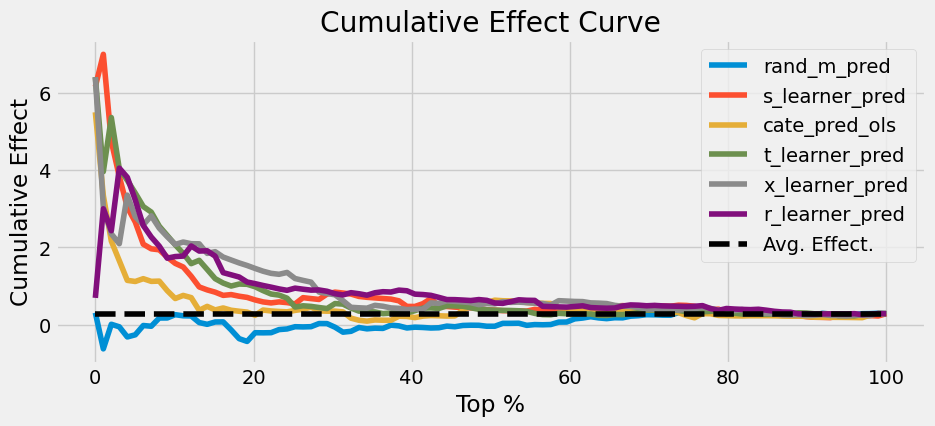

In [33]:
plt.figure(figsize=(10,4))

for m in w_test_pred_spend.columns.drop(["treatment", "spend"]):
    cumu_effect = cumulative_effect_curve(w_test_pred_spend, m, "spend", "treatment", steps=100)
    x = np.array(range(len(cumu_effect)))
    plt.plot(100*(x/x.max()), cumu_effect, label=m)

plt.hlines(effect(w_test_pred_spend, "spend", "treatment"), 0, 100, linestyles="--", color="black", label="Avg. Effect.")
plt.xlabel("Top %")
plt.ylabel("Cumulative Effect")
plt.title("Cumulative Effect Curve")
plt.legend(fontsize=14)

Notice that the random effect model fluctuates around the average efffect line. Double ML model does a better job compared to all models in terms of estimating and ordering CATE. Let us now look at the cummulative gain curve of each model.

### C. The Cummulative Gain Curve



$$f(t) = (\frac{Y_t^T}{N_t^T} - \frac{Y_t^C}{N_t^C}) (N_t^T + N_t^C)$$

* $t$ indicates that the quantity is calcualted for the first t observations, sorted by inferred treatment effect.

Text(0.5, 1.0, 'Cumulative Gain Curve (Normalized)')

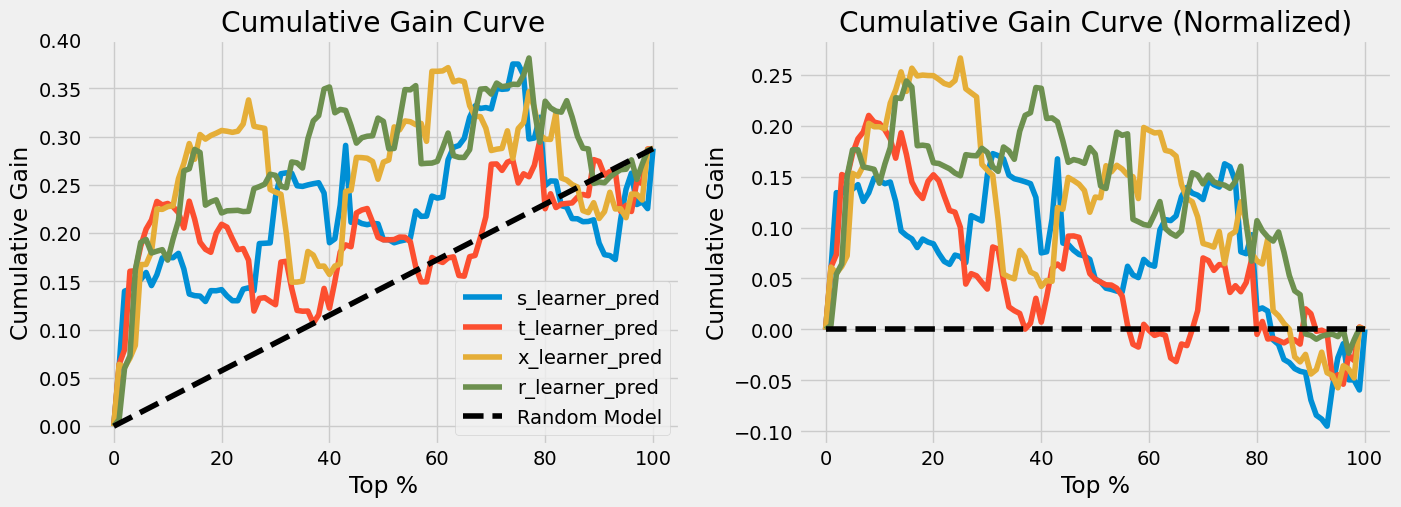

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

for m in w_test_pred_spend.columns.drop(["treatment", "spend", "cate_pred_ols", "rand_m_pred"]):
    cumu_gain = cumulative_gain_curve(w_test_pred_spend, m, "spend", "treatment")
    x = np.array(range(len(cumu_gain)))
    ax1.plot(100*(x/x.max()), cumu_gain, label=m)
    
ax1.plot([0, 100], [0, effect(w_test_pred_spend, "spend", "treatment")], linestyle="--", label="Random Model", color="black")

ax1.set_xlabel("Top %")
ax1.set_ylabel("Cumulative Gain")
ax1.set_title("Cumulative Gain Curve")
ax1.legend()


for m in w_test_pred_spend.columns.drop(["treatment", "spend", "cate_pred_ols", "rand_m_pred"]):
    cumu_gain = cumulative_gain_curve(w_test_pred_spend, m, "spend", "treatment", normalize=True)
    x = np.array(range(len(cumu_gain)))
    ax2.plot(100*(x/x.max()), cumu_gain, label=m)
    
ax2.hlines(0, 0, 100, linestyle="--", label="Random Model", color="black")

ax2.set_xlabel("Top %")
ax2.set_ylabel("Cumulative Gain")
ax2.set_title("Cumulative Gain Curve (Normalized)")

In [35]:
auuc_list = []
for m in w_test_pred_spend.columns.drop(["treatment", "spend", "rand_m_pred"]):
    gain = cumulative_gain_curve(w_test_pred_spend, m, "spend", "treatment", steps=100, normalize=True)
    auuc_list.append([m, gain.sum()])
auuc_df = pd.DataFrame(auuc_list, columns=["Model", "AUC"])
auuc_df_sorted = auuc_df.sort_values(by="AUC", ascending=True).reset_index(drop=True)

auuc_df_sorted

,Model,AUC
0,cate_pred_ols,1.923194
1,t_learner_pred,5.451812
2,s_learner_pred,7.578390
3,x_learner_pred,11.528676
4,r_learner_pred,13.043554


We can also use a pylift library to plot the curve. 

In [36]:
# # pip install pylift
# from pylift.eval import UpliftEval

In [37]:
# import matplotlib.pyplot as plt
# from pylift.eval import UpliftEval  # Ensure you have this imported from the right package

# # Create a 2x3 subplot grid
# fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 2 rows, 3 columns
# axes = axes.flatten()  # Flatten to make it easier to iterate

# # Iterate over the models and create the AQINI plots
# for idx, m in enumerate(w_test_pred_spend.columns.drop(["treatment", "spend", "rand_m_pred", "cate_pred_ols"])):
#     # Create an UpliftEval object for each model
#     upev = UpliftEval(w_df_test_ml['treatment'], w_df_test_ml['spend'], w_test_pred_spend[m])
    
#     # Select the correct subplot axis
#     ax = axes[idx]
    
#     # Plot the AQINI curve on the selected axis
#     upev.plot(plot_type='qini', ax=ax)
    
#     # Add a title for each subplot
#     ax.set_title(f"QINI Curve for {m}")

# # Adjust layout for better spacing between plots
# plt.tight_layout()

# # Show the full figure
# plt.show()
